# PHYS20762 - Project 2 - Numerical Integration of Differential Equations The Damped Harmonic Oscillator


Lukas Wystemp

University of Manchester  
April 2024

In [1]:
# Initialisation and Imports
import numpy as np
import matplotlib.pyplot as plt
import cmath
import matplotlib.animation as animation
from IPython.display import HTML
import time
from scipy.signal import argrelmax

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

# Project Description

A spring-mass system is described by 
\begin{align}
mx''(t)+bx'(t)+kx(t)=F
\end{align}

where $x(t)$ is the position. For this project a value of the spring constant $k = 1.27$ N/m and mass $m = 4.03$ kg was used. The damping constant b will be adjusted as needed. 

There will be 5 parts to this project: 
1) An investigation of the Euler, Improved Euler, Verlet, and Euler-Cromer method to analytically calculate solutions for $x(t)$. They are compared to the analytical solution.

2) The accuracy of the models is investiaged by looking at energy conservation and using a Chi-Squared test.

3) For the best method  solutions for the damping term, b, equal to (i) half of the critical value, (ii) its critical value and (iii) double the critical value are calculated. 

4) A short instantaneous force is applied to the system, and then a sinusoidal force is continuously applied and the effect on displacement investigated.

5) A resonance plot is found for different driving frequencies of the force. 

In [2]:
# Choose some global parameters as described in the project description
MASS = 4.03 # in kg
SPRING_CONSTANT = 1.27 # in kg/s^2
TIME = 140 # The total integration time # in s
TIME_STEPS = np.arange(0.01, 0.11, 0.01) # Values of the time step h which will be investigated

# Initial conditions
X0 = 0 # in m
V0 = -1 # in m/s

# PART 1: FINDING NUMERICAL SOLUTIONS

In part 1, we start by assuming $F = 0$ N and initial conditions $x(0) = 0$ m and $x'(0) = -1$ m/s. 

Different numerical solutions to this spring-mass system will be investigated. We will look at the Euler method, the improved Euler method, the Verlet method, and the Euler-Cromer method which will be compared to the analytical solution which is given below.

## The analytical solution

We also want to compare the numerical solution to the analytical solution to investigate the accuracy of our models.  It is given as the real part of

\begin{align*}
A &= \left(\frac{b}{2i\sqrt{4km - b^2}} + \frac{1}{2}\right)x_0 + \frac{v_0m}{i\sqrt{4km - b^2}} \\
B &= x_0 - A \\
x &= e^{-\frac{bt}{2m}} \left(Ae^{i\frac{\sqrt{4km - b^2}t}{2m}} + Be^{-i\frac{\sqrt{4km - b^2}t}{2m}}\right)
\end{align*}

In [3]:
def analytic_solution(damping_constant, hstep):
    """
    Calculates the analytic solution for the position of a particle under the influence of a spring and 
    damping force.

    Parameters:
    - damping_constant (float): The damping coefficient.
    - hstep (float): The time step size.

    Returns:
    - distance (numpy.ndarray): A 1D array containing the positions at each time step.
    """
    # Always use np.linspace instead of np.arange to avoid error due to different length arrays
    time = np.linspace(0, TIME, int(TIME/hstep))
    
    # Define constants A and B
    A = (damping_constant/(2*1j*cmath.sqrt(4*SPRING_CONSTANT*MASS-damping_constant**2))+1/2)*X0+V0*MASS/(
        cmath.sqrt(4*SPRING_CONSTANT*MASS-damping_constant**2)*1j) 
    B = X0-A
    
    # Analytical solution to x
    distance = np.exp(-damping_constant*time/(2*MASS))*(A*np.exp(1j*cmath.sqrt(
        4*SPRING_CONSTANT*MASS-damping_constant**2)*time/(2*MASS))
                              +B*np.exp(-1j*cmath.sqrt(4*SPRING_CONSTANT*MASS-damping_constant**2)*time/(2*MASS)))
    return distance.real

This analytical solution above is only valid for an underdamped system. This is the case when the damping constant $b < 2 \sqrt{mk}$ but there are other analytical solutions for other values of b which will be investigated in more detail in part 3. 

As the formatting for all plots with numerical solutions is very similar, we use the function below.

In [4]:
def format_plot(damping_constant):
    """
    Formats the plot by adding labels, gridlines, and legends. Responds to different cases of b and calls the
    appropriate solution functions

    Parameters:
    - damping_constant (float): The damping coefficient.

    Returns:
    None
    """
    # Add analytical solution based on damping coefficient. In part 1, only underdamping is considered.
    
    # Underdamped solution
    if damping_constant < 2 * np.sqrt(MASS * SPRING_CONSTANT):
        plt.plot(np.arange(0, TIME, 0.01), analytic_solution(damping_constant, 0.01), 
                 'k--', label = "Underdamped Analytical Solution")
        plt.title("Underdamped Solution") # This is overwritten in part 1, but needed in part 3
    
    # Overdamped solution
    elif damping_constant > 2 * np.sqrt(MASS * SPRING_CONSTANT):
        plt.plot(np.arange(0, TIME, 0.01), overdamping_analytical(damping_constant, 0.01), 
                 'k--', label = "Overdamping Analytical Solution")
        plt.title("Overdamped Solution") # This is overwritten in part 1, but needed in part 3
    
    # Critically damped solution
    else:
        plt.plot(np.arange(0, TIME, 0.01), critical_damping_analytical(damping_constant, 0.01), 
                 'k--', label = "Critical Damping Analytical Solution") 
        plt.title("Critically Damped Solution") # This is overwritten in part 1, but needed in part 3
    
    # Add labels and gridlines
    plt.grid(True)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.xlim(0, TIME) 
    plt.legend()

Now that we have defined the analytical solution, we can start investigating different numerical methods and compare them. 

## The Euler Method

The Euler method is the simplest explicit method for numerical integration of ordinary differential equations. The idea is to use the time derivative of position at a given point to estimate the value of the function at the next point. It exploits the definition of derivatives  $\frac{df(x)}{dx}=\lim_{h \to 0}\frac{f(x+h)-f(x)}{h}$ to derive the equation for displacement $x$ and velocity $v = \frac{dx}{dt}$:

$x_{i+1} =  x_{i} + hv_{i}$

$v_{i+1} =  v_{i} + ha_{i}$

$a_{i} = - \frac{k}{m} x_{i} - \frac{b}{m} v_{i}$ 

where the acceleration $a$ is simply the rearranged differential equation, $h$ is a small time step, and $i$ is the index starting at 0. 

The equation is defined below.

In [5]:
def euler(nsteps, damping_constant, hstep):
    """
    Implements the Euler method to solve the second-order ordinary differential equation.

    Parameters:
    - nsteps (int): The number of steps to taken in the simulation.
    - damping_constant (float): The damping coefficient.
    - hstep (float): The time step size.

    Returns:
    - distance (numpy.ndarray): An array containing the positions at each time step.
    """

    # Create empty arrays
    distance = np.zeros(nsteps)
    velocity = np.zeros(nsteps)
    
    # Initial conditions
    distance[0] = X0
    velocity[0] = V0

    for i in range(nsteps - 1):
        acceleration = -(SPRING_CONSTANT/MASS)*distance[i] - (damping_constant/MASS)*velocity[i]
        distance[i+1] = distance[i] + velocity[i]*hstep
        velocity[i+1] = velocity[i] + acceleration*hstep

    return distance, velocity

Finally, we define b as 0.08 kg/s. Then we simply call the euler function which outputs an array of values of displacement and velocity. 

In [6]:
# Define b
damping_constant = 0.08 # in kg/s

# Initialise the euler method empty array
x_euler = []

# Calculate positions for each time step using different methods and step sizes
for hstep in TIME_STEPS:
    nsteps = int(TIME/hstep)
    
    # Euler
    distance, _ = euler(nsteps, damping_constant, hstep) # Neglect velocity for now
    x_euler.append(distance)

Given the array of calculated values, we can plot it as an animation for different time step sizes h. This visually illustrates how the accuracy of the model improves for smaller h.

In [7]:
# Initialise parameters and call format_plot function
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-', label = "Euler method" + str())  # Line plot
format_plot(damping_constant)
plt.title("Euler Method")
ax.legend(loc = "upper left")

# Update function for the animation
def update(num, x, line, name):
    """
    Update function for the animation. This function is called for each frame of the animation.
    It updates the data of the lines and the legend text.

    Parameters:
    - num (int): The frame number
    - x (array like): Two dimensional array of numerical displacement with each iteration of hstep
    - line (class matplotlib.lines.Line2D): The line object for x
    - name (str): Name of Method being updated
    
    Returns:
    - line (tuple): A tuple containing the updated line objects.
    
    """
    # Update line object
    line.set_data(np.linspace(0, TIME, len(x[num])), x[num])

    # Create a new legend with the updated text    
    ax.legend([f"{name} Method, h = {TIME_STEPS[num]:.2g}", "Underdamped Analytical solution"], 
              loc="upper left", fontsize=7)
    
    return line, 

# Create the animation
ani = animation.FuncAnimation(fig, update, len(x_euler), fargs=[x_euler, line, "Euler"],
                              interval=200, blit=True)
plt.close() # Close animation to prevent stationary frames

# Display the animation
HTML(ani.to_jshtml())

The graph above shows the Euler Method Plot at different time steps (h) and the analytical soltuion. It is an approximation to the oscillator's displacement and motion. The greater the stepsize, the less accurate the approximation, but computational speed increases. As the time step increases beyond $\approx 0.08$  the amplitude seems to be increasing which is impossible in a damped and undriven system. This hints at the fact that the energy is not conserved when calculating displacement using the Euler method, as well as suggesting high inaccuracies. 

## Improved Euler

The improved Euler method takes an average of the slopes at the beginning and end of the interval which is why it is also called trapezoidal rule. Hence, it calculates the next value. The formulae are 

$ x_{i+1} = x_{i} + h_i + \frac{h^2}{2}a_i$

$v_{i+1} = v_{i} + ha_i$ 

and $a_i$ is the same as above. 

It is defined below:

In [8]:
def improved_euler(nsteps, damping_constant, hstep):
    """
    Implements the Improved Euler method to solve a second-order ordinary differential equation.

    Parameters:
    - nsteps (int): The number of steps to take in the simulation.
    - damping_constant (float): The damping coefficient.
    - hstep (float): The time step size.

    Returns:
    - distance (numpy.ndarray): An array containing the positions at each time step.
    """
    
    # Create empty arrays
    distance = np.zeros(nsteps)
    velocity = np.zeros(nsteps)
    acceleration = np.zeros(nsteps)
    
    # Initial conditions
    distance[0] = X0
    velocity[0] = V0

    for i in range(nsteps-1):
        # Calculate acceleration # equivalently to the Euler method
        acceleration[i] = -(SPRING_CONSTANT/MASS)*distance[i] - (damping_constant/MASS)*velocity[i]
        
        # Update position and velocity using Improved Euler method
        distance[i + 1] = distance[i] + hstep * velocity[i] + hstep**2 / 2 * acceleration[i]
        velocity[i + 1] = velocity[i] + hstep * acceleration[i]
    
    return distance, velocity

We can conveniently reuse the functions for the analytical solution, to format the plot, and to calculate the animation from above and hence we plot the numerical and analytical solution again.

In [9]:
# Define empty array
x_improved_euler = []

# Calculate positions for each time step using different methods and step sizes
for hstep in TIME_STEPS:
    nsteps = int(TIME/hstep)
    
    # Euler
    distance, _ = improved_euler(nsteps, damping_constant, hstep)
    x_improved_euler.append(distance)

# Plot the Improved Euler Method
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-', label = "Improved Euler method" + str())  # Line plot
format_plot(damping_constant)
plt.title("Improved Euler Method")
ax.legend(loc = "upper left")

# Create the animation
ani = animation.FuncAnimation(fig, update, len(x_improved_euler), fargs=[x_improved_euler, line, "Improved Euler"],
                              interval=200, blit=True)
plt.close()

# Display the animation
HTML(ani.to_jshtml())

The graph above displays the improved Euler method. It is immediately apparent, that this method is more accurate than the original Euler method. Even at larger step sizes, such as h = 0.1, the amplitude does not increase over time. Though more promising than the original Euler method, the inaccuracies are clearly visible.

## The Verlet Method

The Verlet method calcules the next position based on the current and previous position, and the acceleration.

Using Verlet's we can use the terms

$ x_{i+1} = 2x_i - x_{i-1} + h^2a_i + O(h^4), $

$ a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i, $

$ v_{i+1} = \frac{1}{2h}(x_{i+1}-x_{i-1})$

However, these can't be solved separately, so we rearange for $x$ while combining the equations to give

$ x_{i+1} = Ax_i + Bx_{i-1}, $


where

$ A = 2\frac{2m - kh^2}{2m + bh} $,

$B = \frac{bh - 2m}{2m + bh} $,

As the $i+1$ term requires $i$ and $i-1$ this is not self starting. Instead, we must use a different method (in this case Euler) to calculate the first step. 

In [10]:
def verlet(nsteps, damping_constant, hstep):
    """
    Implements the Verlet method to solve a second-order ordinary differential equation.

    Parameters:
    - nsteps (int): The number of steps to take in the simulation.
    - damping_constant (float): The damping coefficient.
    - hstep (float): The time step size.

    Returns:
    - x (numpy.ndarray): An array containing the positions at each time step.
    """
    distance = np.zeros(nsteps)
    velocity = np.zeros(nsteps)
    acceleration = np.zeros(nsteps)

    distance[0] = X0
    velocity[0] = V0

    for i in range(nsteps - 1):
        # Calculate acceleration at the current time step
        acceleration[i] = -(SPRING_CONSTANT/MASS)*distance[i] - (damping_constant/MASS)*velocity[i]

        # Update position and velocity using the Verlet method
        distance[1] = distance[0] + hstep * velocity[0] + hstep**2 / 2 * acceleration[0]
        velocity[1] = velocity[0] + hstep * acceleration[0]

        # Calculate coefficients for the Verlet method
        D = 2 * MASS + damping_constant * hstep
        A = 2 * (2*MASS - SPRING_CONSTANT * hstep**2) / D
        B = (damping_constant * hstep - 2 * MASS) / D

        # Update position using the Verlet method
        distance[i + 1] = A * distance[i] + B * distance[i - 1]
        velocity[i+1] = (distance[i+1] - distance[i-1]) / (2 * hstep)

    return distance, velocity

In [11]:
# Define array
x_verlet = []

# Calculate displacement using the Verlet method
for hstep in TIME_STEPS:
    nsteps = int(TIME/hstep)
    
    # Verlet
    distance, _ = verlet(nsteps, damping_constant, hstep)
    x_verlet.append(distance)


# Plot the Verlet Method
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-', label = "Verlet method" + str())  # Line plot
format_plot(damping_constant)
plt.title("Verlet Method")
ax.legend(loc = "upper left")

# Create the animation
ani = animation.FuncAnimation(fig, update, len(x_verlet), fargs=[x_verlet, line, "Verlet"],
                              interval=200, blit=True)
plt.close()

# Display the animation
HTML(ani.to_jshtml())

The Verlet method seems like a very good approximation. Even at large h, such as $h=0.1$ s, the numerical solution is seeminlgy perfect; unlike the Euler and improved Euler method.

## Euler-Cromer Method

The Euler-Cromer method is a modification to the Euler method which calculates the new velocity before the new position. This subtle change can have significant effects on the accuracy, particularly considering energy conservation (as we will see in part 2).


$v_{i + 1} = v_{i} + ha_{i}$

$x_{i + 1} = x_i + hv_{i + 1}$

and $a$ is the same as in the Euler and Improved Euler method.


In [12]:
def euler_cromer(nsteps, damping_constant, hstep):
    """
    Implements the Euler-Cromer method to solve a second-order differential equation
    describing the motion of a particle under the influence of a spring and damping force.

    Parameters:
    - nsteps (int): Number of time steps to take.
    - damping_constant (float): Damping coefficient.
    - hstep (float): Time step size.

    Returns:
    - distance (numpy.ndarray): Array of positions at each time step.
    """

    # Create empty arrays
    distance = np.zeros(nsteps)
    velocity = np.zeros(nsteps)
    acceleration = np.zeros(nsteps)

    # Initial conditions
    distance[0] = X0
    velocity[0] = V0
        
    for i in range(nsteps - 1):
        acceleration[i] = -(SPRING_CONSTANT/MASS)*distance[i] - (damping_constant/MASS)*velocity[i]
        velocity[i+1] = velocity[i] + acceleration[i] * hstep
        distance[i+1] = distance[i] + velocity[i+1] * hstep
    
    return distance, velocity

In [13]:
# Define array
x_euler_cromer = []

# Calculate positions for each time step using different methods and step sizes
for hstep in TIME_STEPS:
    nsteps = int(TIME/hstep)
    
    # Euler-Cromer
    distance, _ = euler_cromer(nsteps, damping_constant, hstep)
    x_euler_cromer.append(distance)

# Plot the Euler-Cromer Method
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-', label = "Euler-Cromer method" + str())  # Line plot
format_plot(damping_constant)
plt.title("Euler-Cromer Method")
ax.legend(loc = "upper left")

# Create the animation
ani = animation.FuncAnimation(fig, update, len(x_euler_cromer), fargs=[x_euler_cromer, line, "Euler-Cromer"],
                              interval=200, blit=True)
plt.close()

# Display the animation
HTML(ani.to_jshtml())

Much like the Verlet method, the displacement of the Euler-cromer Method is very close to the analytical function and it is not changing much depending on h.

In part 2, the accuracy of the models will now be investigated further. 

# PART 2: INVESTIGATING THE ACCURACY OF THE MODELS

## Energy conservation

In a system with damping, energy is not conserved, but some is lost through friction, air resistance, etc. By looking at the total energy, the sum of kinetic and potential energy as given by
\begin{align}
E=\frac{1}{2}kx^2+\frac{1}{2}mv^2
\end{align}
we expect a steady decrease over time. 

We can compare the models with each other first, and later how the step size affects this. 

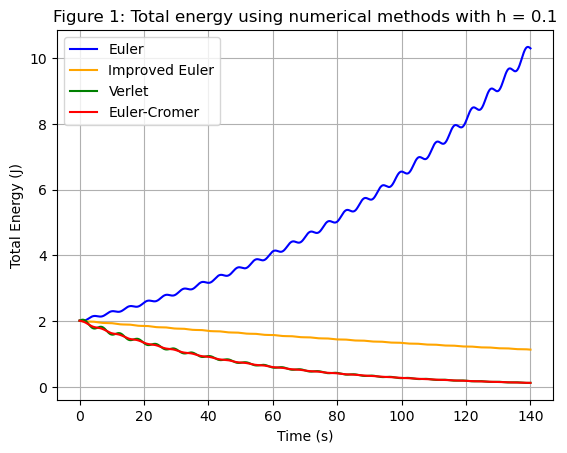

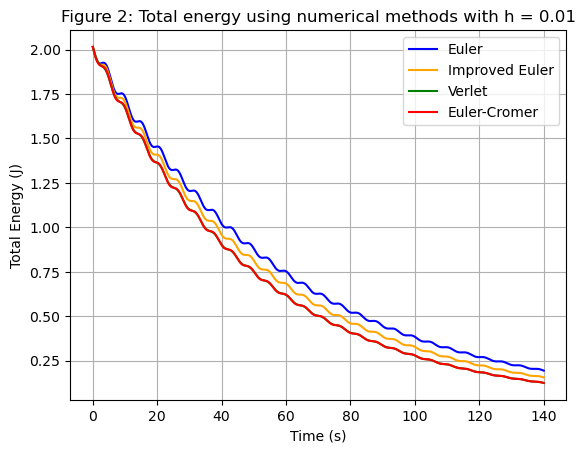

In [14]:
def calculate_energy(distance, velocity):
    """
    Calculates the total energy of the system using the standard formula E = 1/2 k x^2 + 1/2 m v^2

    Parameters:
    - distance (numpy.ndarray): 1D array of numerical and analytical displacmeent values
    - velocity (numpy.ndarray): 1D array of numerical and analytical velocity values

    Returns:
    - (numpy.ndarray): 1D array of energy values
    
    
    """
    return (1/2) * (SPRING_CONSTANT * distance ** 2) + (1/2) * (MASS * velocity ** 2)

# Use only two h value to save some computational cost (my laptop is dying)
h = [0.1, 0.01] 
num = 0 # Iteration

# Instead of calculating displacement only (like in part 1), we will calculate both disaplcement and velocity. This
# is then used in the function calculate_energy() to find a value of E at each point. 
for hstep in h:
    nsteps = int(TIME/hstep)
    time = np.linspace(0, TIME, int(TIME/hstep))
    
    num += 1 # Number of figure, either 1 or 2
    
    # Euler
    distance, velocity = euler(nsteps, damping_constant, hstep)
    energy_euler = calculate_energy(distance, velocity)
    plt.plot(time, energy_euler, color = 'b', label = "Euler")

    # Improved Euler
    distance, velocity = improved_euler(nsteps, damping_constant, hstep)
    energy_improved_euler = calculate_energy(distance, velocity)
    plt.plot(time, energy_improved_euler, color = 'orange', label = "Improved Euler")
    
    # Verlet
    distance, velocity = verlet(nsteps, damping_constant, hstep)
    energy_verlet = calculate_energy(distance, velocity)
    plt.plot(time, energy_verlet, color = 'green', label = "Verlet")
    
    # Euler-Cromer
    distance, velocity = euler_cromer(nsteps, damping_constant, hstep)
    energy_euler_cromer = calculate_energy(distance, velocity)
    plt.plot(time, energy_euler_cromer, color =  'red', label = "Euler-Cromer")
    
    # Formatting the graph, for each value of h a graph is plotted
    plt.grid(True)
    plt.legend()
    plt.title(f"Figure {num}: Total energy using numerical methods with h = {hstep}")
    plt.xlabel("Time (s)")
    plt.ylabel("Total Energy (J)")
    plt.show()

**Figure 1**: The Euler method demonstrates a notable drawback in its failure to conserve energy, leading to an  increase in total energy. This discrepancy renders it unsuitable for computations involving large step sizes. Similarly, the Improved Euler method displays a decrease in energy, albeit less prominently compared to the Verlet and Euler-Cromer methods.

All methodologies exhibit some degree of oscillatory behavior, albeit to varying extents. The improved Euler method demonstrates the least oscillations. While the theoretical formula predicts a uniform rate of energy dissipation, the presence of oscillations indicates inherent inaccuracies across all methods, however, they are less prominent in the improved Euler method. The Euler-Cromer method also displays fewer oscillations.

**Figure 2**: At smaller step sizes, the Euler method performs notably better than in figure 1, more closely aligning with the Verlet and Improved Euler methods. The Verlet method and Euler-Cromer method are very close, predicting the energy very well at all times, both in figure 1 and 2. Consequently, while the Euler method is acceptable for energy calculations with reduced step sizes, the Verlet and Euler-Cromer methods exhibit superior performance overall.

It can also be instructive to look at how the step size affects the accuracy of the models.

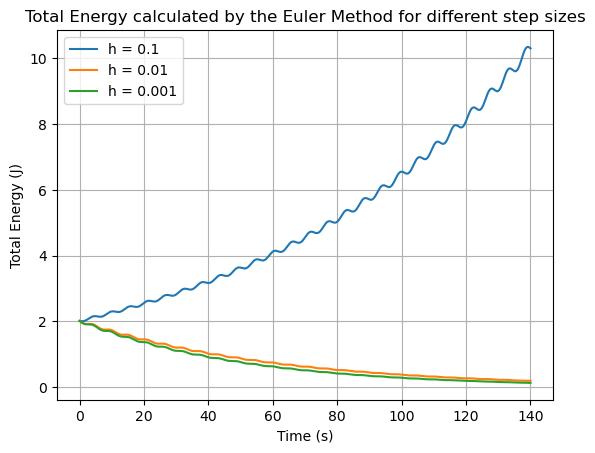

In [15]:
h = [0.1, 0.01, 0.001] # Define the h steps for which the energy will be calculated

# Format energy plots
def format_energy_plot(method): 
    """
    Formats the plots for energies considering different h steps

    Parameters:
    - method (str): name of the method being plotted

    Returns:
    - None
    
    """
    plt.grid(True)
    plt.legend()
    plt.title(f"Total Energy calculated by the {method} Method for different step sizes")
    plt.xlabel("Time (s)")
    plt.ylabel("Total Energy (J)")
    plt.show()

for hstep in h:
    nsteps = int(TIME/hstep)
    time = np.linspace(0, TIME, int(TIME/hstep))
    
    # Euler
    distance, velocity = euler(nsteps, damping_constant, hstep)
    energy_euler = calculate_energy(distance, velocity)
    plt.plot(time, energy_euler, label = f"h = {hstep}")
format_energy_plot("Euler")

As seen above, the Euler method is very poor at conserving energy, particularly at large h as the total energy of the system is increasing. The inaccuracies become larger with long-term simulations for higher t, increasing exponentially for h = 0.1 However, for smaller h, such as 0.01, and 0.001, the simulations are more accurate. 

For all h, the simulation is oscillating a lot, which means that the Euler method should not be used when short-term trends are investigated, and only used for long-term trends with sufficiently small step sizes. 

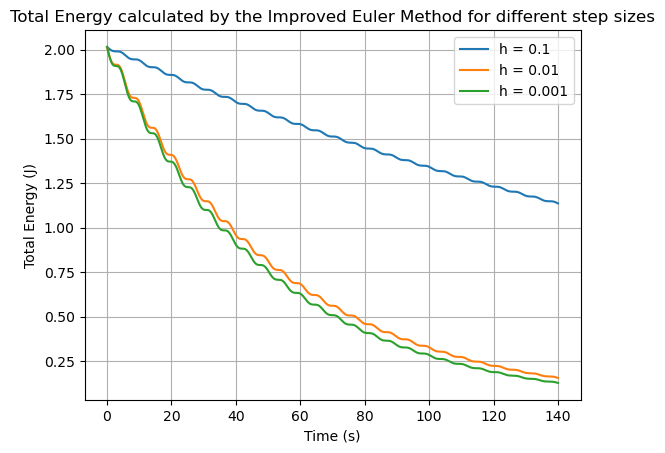

In [16]:
for hstep in h:
    nsteps = int(TIME/hstep)
    time = np.linspace(0, TIME, int(TIME/hstep))
    
    # Improved Euler
    distance, velocity = improved_euler(nsteps, damping_constant, hstep)
    energy_euler = calculate_energy(distance, velocity)
    plt.plot(time, energy_euler, label = f"h = {hstep}")
format_energy_plot("Improved Euler")

Similar to the Euler method above, for large h the model is a poor predictor of the energy, however, becomes better at small h. Overall, the Improved Euler method is better than the Euler method as energy is decreasing (as expected) for all values of h, though be it with high inaccuracies. 

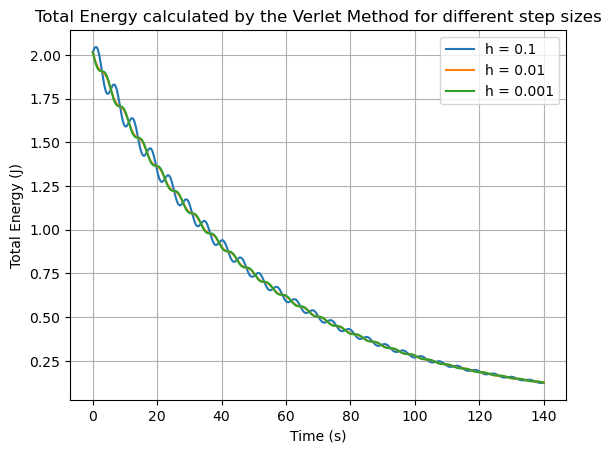

In [17]:
for hstep in h:
    nsteps = int(TIME/hstep)
    time = np.linspace(0, TIME, int(TIME/hstep))
    
    # Verlet
    distance, velocity = verlet(nsteps, damping_constant, hstep)
    energy_euler = calculate_energy(distance, velocity)
    plt.plot(time, energy_euler, label = f"h = {hstep}")
format_energy_plot("Verlet")

Because the verlet method is more complex than other methods, it conserves energy better, especially in long-term simulations. 

The graph shows the Verlets method and its superior performance. Even at large step sizes, such as h = 0.1, the oscillations are small and the predictions close to smaller h steps. However, oscillations around the trend line are larger than for the Euler-Cromer method below.

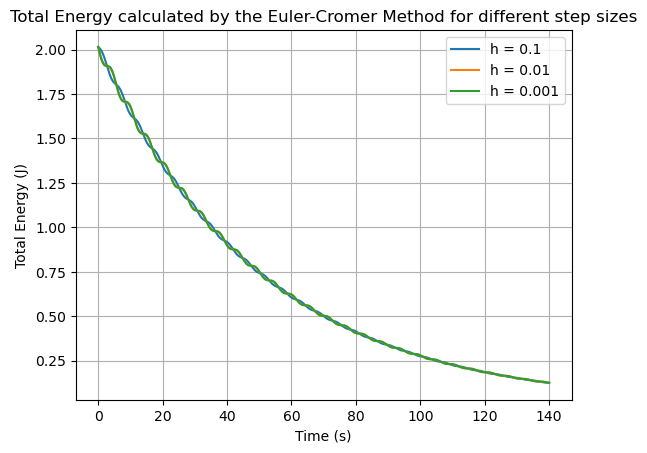

In [18]:
for hstep in h:
    nsteps = int(TIME/hstep)
    time = np.linspace(0, TIME, int(TIME/hstep))
    
    # Euler
    distance, velocity = euler_cromer(nsteps, damping_constant, hstep)
    energy_euler = calculate_energy(distance, velocity)
    plt.plot(time, energy_euler, label = f"h = {hstep}")
format_energy_plot("Euler-Cromer")

Unlike the Euler method, the Euler-Cromer method is a sympletic integrator, which means it is energy-conserving, however, has been adjusted for this specific system to take energy losses through damping into account. As such, it is an excellent calculator of energy. The oscillations around the trend are small and it is very accurate even at large h, only being rivaled by the Verlet method. 

## The Goodness of fit test

A way to quantify the accuracy of the models better is by calculating the $\chi^2_{red}$ of the numerical methods in comparison to the analytical solution as a function of h.

A value of $b=0.08$ kg/s was chosen again.

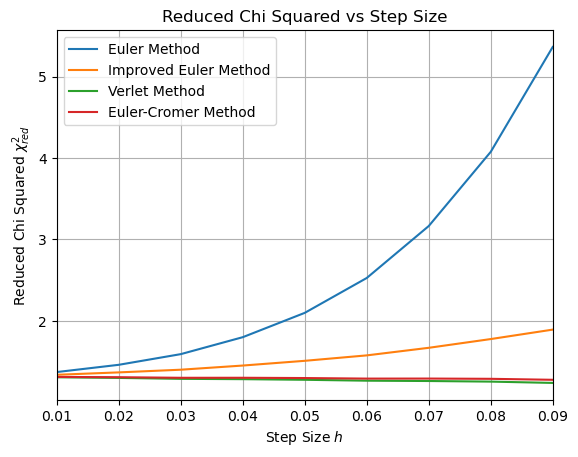

In [19]:
def goodness_of_fit(analytical, numerical):
    """
    Calculates the goodness of fit between the analytical and numerical solutions.

    Parameters:
    - analytical (numpy.ndarray): 1D array containing the analytical solution.
    - numerical (numpy.ndarray): 1D array containing the numerical solution.

    Returns:
    - float: The goodness of fit value.
    """
    return np.sum((analytical - numerical)**2)/np.sum(analytical**2)

def calculate_chi_squared(damping_constant):
    """
    Calculates the reduced chi-squared values for different numerical methods and step sizes. 
    Then plots graph of chi-squared over step size

    Parameters:
    - damping_constant (float): The damping coefficient.

    Returns:
    None
    """
    # Values of h to calculate chi-squared for
    h = np.arange(0.01, 0.1, 0.01)
    
    # Initialise empty arrays
    chi_euler = []
    chi_improved_euler = []
    chi_verlet = []
    chi_euler_cromer = []
    
    # Append chi squared for each value of h by calling goodness_of_fit
    for hstep in h:
        chi_euler.append(goodness_of_fit(analytic_solution(damping_constant, hstep), 
                                         euler(int(TIME/hstep), damping_constant, hstep)))
        chi_improved_euler.append(goodness_of_fit(analytic_solution(damping_constant, hstep), 
                                                  improved_euler(int(TIME/hstep), damping_constant, hstep)))
        chi_verlet.append(goodness_of_fit(analytic_solution(damping_constant, hstep), 
                                          verlet(int(TIME/hstep), damping_constant, hstep)))
        chi_euler_cromer.append(goodness_of_fit(analytic_solution(damping_constant, hstep), 
                                                euler_cromer(int(TIME/hstep), damping_constant, hstep)))

    # Plots chi-squared graph
    plt.plot(h, chi_euler, label = "Euler Method")
    plt.plot(h, chi_improved_euler, label = "Improved Euler Method")
    plt.plot(h, chi_verlet, label = "Verlet Method")
    plt.plot(h, chi_euler_cromer, label = "Euler-Cromer Method")
    plt.xlabel("Step Size $h$")
    plt.ylabel("Reduced Chi Squared $\chi^2_{red}$")
    plt.title("Reduced Chi Squared vs Step Size")
    plt.legend(loc = "upper left")
    plt.grid(True)
    plt.xlim(h[0], h[-1])
    plt.show()
    
    
# Call function
calculate_chi_squared(0.08)

It is obvious that the Verlet method is the most accurate as its reduced chi-squared is almost 0 for all values of h. However, the Euler-Cromer method is very close, only exhibiting a slightly larger $\chi^2_{red}$. Both are very constant in their inaccuracy, not significantly increasing with step size. 

Both the Euler method and the Improved Euler method yield higher inaccuracies than the Verlet method, especially at higher values of h when smaller errors multiply. However, they both are also very accurate at low step sizes. 

In conclusion, the Verlet method is the most accurate computational mode, closely followed by the Euler-Cromer method, which particularly stands apart in energy calculations. 

In [20]:
print("Runtime for the Euler method:")
%timeit -o euler(nsteps, damping_constant, hstep)
print("\nRuntime for the improved Euler method:")
%timeit -o improved_euler(nsteps, damping_constant, hstep)
print("\nRuntime for the Verlet method:")
%timeit -o verlet(nsteps, damping_constant, hstep)
print("\nRuntime for the Euler-Cromer method:")
%timeit -o euler_cromer(nsteps, damping_constant, hstep)

Runtime for the Euler method:
256 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Runtime for the improved Euler method:
320 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Runtime for the Verlet method:
578 ms ± 4.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Runtime for the Euler-Cromer method:
282 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 282 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

We can see that the time per loop is the highest for the Verlet method, and the lowest for the Euler-Cromer method. This means that even though the Verlet method is the best in terms of the $\chi_{red}^2$, the Euler-Cromer method may be preferable in some applications due to its very low CPU time. 

In conclusion, the Euler-Cromer method is very good for energy calculations and requires the least CPU power. It's $\chi_{red}^2$ is very low. However, the Verlet method has an even lower $\chi_{red}^2$ for all values of h, but comes at the drawback of high computational requirements. As it is the most accurate, it will be used moving forward, however, for very computationally extensive tasks, the Euler-Cromer method may be a good alternative, particularly for energy calculations. 

# PART 3: SOLVING FOR DIFFERENT VALUES OF DAMPING

The function format_plot() automatically determines which analytical solution should be used depending on the value of the damping constant, b. If the critical value $b^2_{cr} <4km$, we speak of an underdamped system, the solution of which has already been used above in part 1. If $b^2_{cr} > 4km$, we have an overdamped system, and if $b^2_{cr} = 4km$ a critically damped one. 

We plot solutions for the damping term, b, equal to

i) half of the critical value

ii) its critical value and

iii) double the critical value

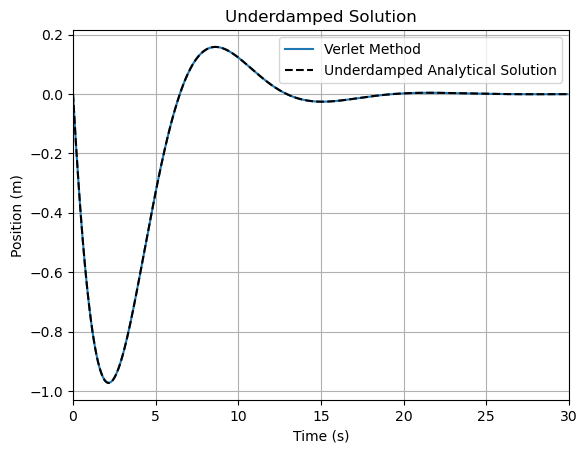

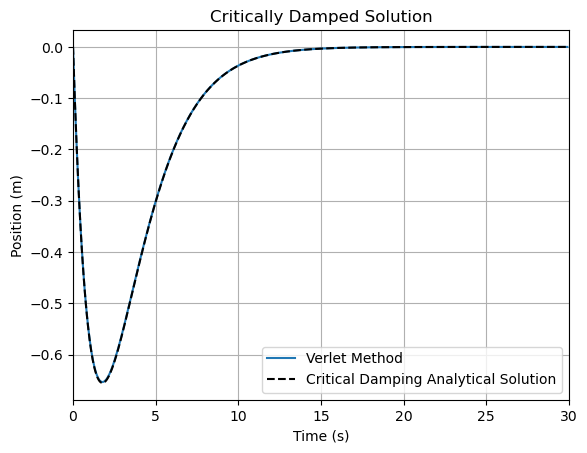

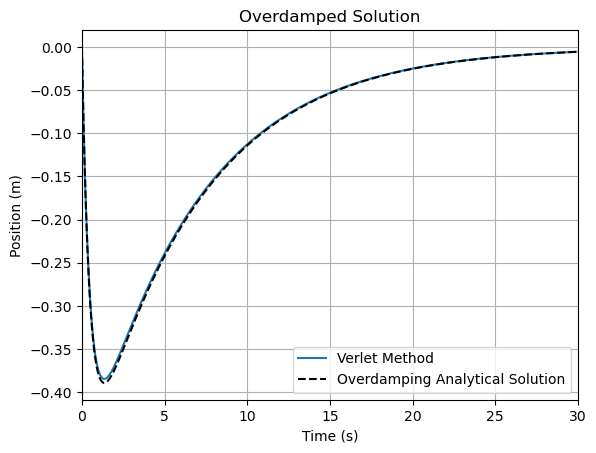

In [21]:
# Define the overdamping solution
def overdamping_analytical(damping_constant, hstep):
    """
    Calculate the position of a damped harmonic oscillator with overdamping using analytical solution.

    Parameters:
    - damping_constant (float): Damping coefficient.
    - hstep (float): Time step size.

    Returns:
    - distance (numpy.ndarray): Array of positions of the oscillator at different time steps.
    """

    time = np.linspace(0, TIME, int(TIME/hstep))
    
    D = damping_constant**2 - 4*MASS*SPRING_CONSTANT
    if D > 0:
        # check if the roots are real or complex
        r1 = -damping_constant/(2*MASS) + np.sqrt(damping_constant**2/(2*MASS)**2 - SPRING_CONSTANT/MASS)
        r2 = -damping_constant/(2*MASS) - np.sqrt(damping_constant**2/(2*MASS)**2 - SPRING_CONSTANT/MASS)
    else:
        print("Error")

    A = (r2*X0 - V0) / (r2 - r1)
    B = (r1*X0 - V0) / (r1 - r2)

    distance = A*np.exp(r1*time) + B*np.exp(r2*time)

    return distance

# Define the critical dampign solution
def critical_damping_analytical(damping_constant, hstep):
    """
    Calculates the displacement of a critically damped oscillator analytically.

    Parameters:
    - damping_constant (float): Damping coefficient.
    - hstep (float): Time step size.

    Returns:
    - distance (numpy.ndarray): Array of displacements at each time step.
    """
    time = np.linspace(0, TIME, int(TIME/hstep))
    
    A = X0
    B = V0 + damping_constant/(2*MASS) * X0
    distance = (A + B*time)*np.exp(-damping_constant/(2*MASS)*time)
    return distance

# Iterates throuhg damping_constants as specified above
damping_constants = [(np.sqrt(4*SPRING_CONSTANT*MASS)/2), 
                     np.sqrt(4*SPRING_CONSTANT*MASS), 
                     2*np.sqrt(4*SPRING_CONSTANT*MASS)]

TIME = 30 # Redefine the maximum time of integration so the relevant sections of the graphs are easier to see
# Plots three graphs for each value of the damping constants
for b in damping_constants:
    hstep = 0.1
    nsteps = int(TIME/hstep)
    x_verlet, _ = verlet(nsteps, b, hstep)
    
    plt.plot(np.arange(0, TIME, 0.1), x_verlet, label = "Verlet Method")
    format_plot(b)
    plt.show()

i) $b^2_{cr} <4km$: This indicates underdamping, where the damping force is less than what is required to achieve critical damping. As a result, the system will oscillate around its equilibrium position, gradually decaying over time without overshooting. The oscillations will have a decreasing amplitude. In this case, the damping constant is quite large, hence only one oscillation is observed. 

ii) $b^2_{cr}=4km$: This represents critical damping, where the damping force is precisely sufficient to make the system return to its equilibrium position without oscillating. Critical damping results in the fastest approach to equilibrium without overshooting.

iii) $b^2_{cr} >4km$: This indicates overdamping, where the damping force is excessive, causing the system to return to equilibrium very slowly without oscillation. The system takes longer to settle than in the critically damped case. We can see that the Verlet Method struggles to accurately follow the analytical solution at troughs. This is because the relative step size at that point is too large to account for a very rapid change. There is a balance between reducing the step size and some minor inaccuracies along the graph. 

The three cases i, ii, and iii can further be observed below, where an animated graph cycles through a range of values of b. 

In [22]:
# Initialise some parameters (feel free to change them at your will and observe the change in the animated graph)
TIME = 40
constant = np.sqrt(4*SPRING_CONSTANT*MASS)
damping_constants = np.arange(constant/8, constant * 2, constant/8)

# Define lines
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-', label = "Damping" + str())  # Line plot
line_analytical, = ax.plot([], [], 'k--', label = "lol ")

# Fix legend in place, otherwise it tends to be confused by matplotlib's autoplacement
ax.legend(loc = "upper left")

# Define empty arrays
x_verlet = []
x_analytical = []
name = []

# Calculate 2D arrays containing animation frames in axis=0 and values in axis=1
for b in damping_constants:

    # Calculate numerical solution
    distance, _ = verlet(int(TIME/0.1), b, 0.1)
    x_verlet.append(distance)

    # Calculate numerical solution
    if b < 2 * np.sqrt(MASS * SPRING_CONSTANT):
        x_analytical.append(analytic_solution(b, 0.01))
        name.append("Underdamped")
    elif b > 2 * np.sqrt(MASS * SPRING_CONSTANT):
        x_analytical.append(overdamping_analytical(b, 0.01))
        name.append("Overdamped")
    else:
        x_analytical.append(critical_damping_analytical(b, 0.01))
        name.append("Critically damped")
        
# Add labels and gridlines
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.xlim(0, TIME) 
plt.ylim(np.amin(x_analytical), np.amax(x_analytical))
plt.legend()
    
# Update function for the animation
def update(num, x, line, name):
    """
    Update function for the animation. This function is called for each frame of the animation.
    It updates the data of the lines and the legend text.

    Parameters:
    - num (int): The frame number
    - x (array like): Two dimensional array of numerical displacement with each iteration of hstep
    - line (class matplotlib.lines.Line2D): The line object for x
    - name (str): Name of analytical solution being updated, either Underamped, overdamped, or critically damped
    
    Returns:
    - line (tuple): A tuple containing the updated line objects.
    
    """
    # Update line objects
    line.set_data(np.linspace(0, TIME, len(x[num])), x[num])
    line_analytical.set_data(np.linspace(0, TIME, len(x_analytical[num])), x_analytical[num])

    # Create a new legend with the updated text    
    ax.legend([f"Verlet Method", f"{name[num]} analytical solution"], 
              loc="upper left", fontsize=7)
    
    return line, line_analytical,

# Create the animation
ani = animation.FuncAnimation(fig, update, len(x_verlet), fargs=[x_verlet, line, name],
                              interval=200, blit=True)
# Prevents stationary image after animation is finished
plt.close()

# Displays the animation
HTML(ani.to_jshtml())

Note how for larger b in the case of underdamping, the period remains the same, but the amplitude decreases rapidly as the rate of energy dissipation increases. The displacement then reaches 0 the fasted for a brief moment when the system experiences critical damping, and then goes over to overdamping where no oscillations occur.

# Part 4: Applying a force to the system

In parts 1-3, we assumed an unforced system. Now we are going to apply different forces to the system. 

## Applying an instantaneous force
First, we are going to apply an instantaneous force where we assume a constant force for a very short period of time t. These systems have very complicated analytical solutions (or none at all), so we are again using the Verlet method because we found earlier that it is the most accurate. 

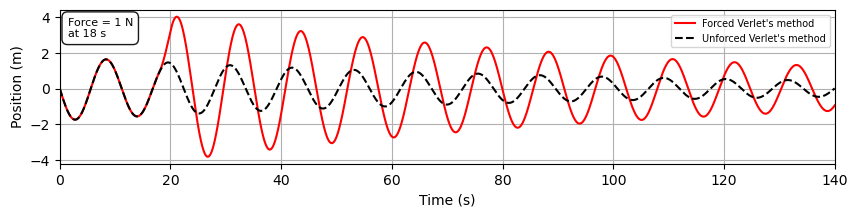

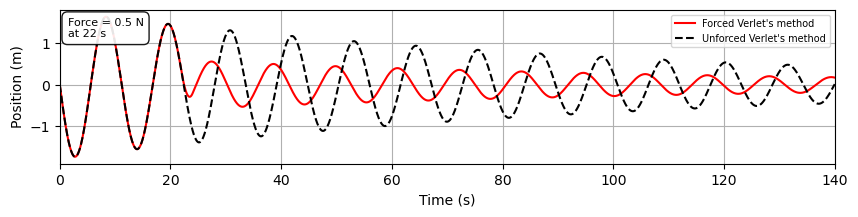

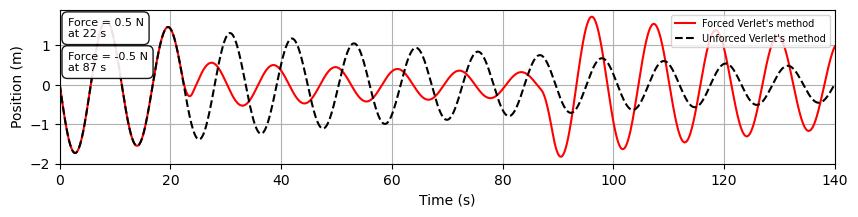

In [23]:
TIME = 140
damping_constant = 0.08

# We need to adjust the Verlet method to consider force as well. The only thing that changes is acceleration which
# is rearranged from the original differential equation mx''(t)+bx'(t)+kx(t)=F, rearranged for acceleration.
def verlet_force(nsteps, damping_constant, hstep, force):
    """
    Implements the Verlet integration method to solve a second-order differential equation
    for a particle under the influence of a force.

    Parameters:
    - nsteps (int): The number of time steps to perform.
    - damping_constant (float): The damping coefficient.
    - hstep (float): The time step size.
    - force (array-like): An array-like object containing the force values at each time step.

    Returns:
    - distance (array): An array containing the position values at each time step.
    """

    distance = np.zeros(nsteps)
    velocity = np.zeros(nsteps)
    acceleration = np.zeros(nsteps)

    distance[0] = X0
    velocity[0] = V0

    for i in range(nsteps - 1):
        acceleration[0] = -(SPRING_CONSTANT/MASS)*distance[0] - (damping_constant/MASS)*velocity[0]
        distance[1] = distance[0] + hstep * velocity[0] + hstep**2 / 2 * acceleration[0]
        velocity[1] = velocity[0] + hstep * acceleration[0]

        D = 2 * MASS + damping_constant * hstep
        A = 2 * (2*MASS - SPRING_CONSTANT * hstep**2) / D
        B = (damping_constant * hstep - 2 * MASS) / D

        distance[i + 1] = A * distance[i] + B * distance[i - 1] + hstep **2 * force[i + 1]
    return distance

# Needs different specifications, so can't use format_plot() from above
def format_force_plot():
    """
    Formats the force plot by adding gridlines, labeling the x and y axes,
    and setting the x-axis limits.

    Parameters:
        None

    Returns:
        None
    """
    plt.grid(True)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.xlim(0, TIME)
    plt.show()

    
# Calls the verlet method to calculate the displacement for an application of the force
def instantaneous_force(damping_constant, duration_of_force, strength_of_force, start_time):
    """
    Calculate the position of a particle using Verlet's method with an instantaneous force.

    Parameters:
    damping_constant (float): Damping coefficient.
    duration_of_force (array-like): Array-like object containing the durations of the applied forces.
    strength_of_force (array-like): Array-like object containing the strengths of the applied forces.
    start_time (array-like): Array-like object containing the start times of the applied forces.

    Returns:
    None

    """
    hstep = 0.01
    nsteps = int(TIME/hstep)

    # Force = None, for comparison
    force = np.zeros(nsteps)
    x_unforced = verlet_force(nsteps, damping_constant, hstep, force)
    
    # Force != None
    force = np.zeros(nsteps)
    for duration, strength, start in zip(duration_of_force, strength_of_force, start_time):
        start_index = int(start/hstep)
        end_index = int((start + duration)/hstep)
        force[start_index:end_index] += strength
 
    x_forced = verlet_force(nsteps, damping_constant, hstep, force)

    # Plot
    plt.figure(figsize=(10, 2))
    plt.plot(np.arange(0, TIME, hstep), x_forced, 'r', label="Forced Verlet's method")
    plt.plot(np.arange(0, TIME, hstep), x_unforced, 'k--', label="Unforced Verlet's method")
    
    num = 0.95 # amount by which the text box is shifted down each iteration
    for strength, start in zip(strength_of_force, start_time):
        plt.text(0.01, num, f'Force = {strength} N\nat {start} s', verticalalignment='top', 
                horizontalalignment='left', transform=plt.gca().transAxes, 
                bbox=dict(facecolor="white", alpha = 0.9, edgecolor="black", 
                 boxstyle = "round, pad = 0.5"), fontsize = 8)
        num -= 0.22 # shift box down by 22% of the graph, which corresponds to the height of the box
    
    plt.legend(loc="upper right", fontsize=7)
    format_force_plot()

# We use the same values of a damping constant (0.08) and the duration of the force (2s). 
# The strength of the force for the first two graphs is 1N up at 18s and 0.5N up at 22s. In the third graph, 
# the force is applied twice. First, 0.5N up at t = 22s and then 0.5N down at t = 100s.

# If you want to change these values, the function takes (damping_constant, duration of force, strength of force, 
# start time)
# Make sure all arrays have the same length
instantaneous_force(damping_constant, [2], [1], [18])
instantaneous_force(damping_constant, [2], [0.5], [22])
instantaneous_force(damping_constant, [2,2], [0.5, -0.5], [22, 87])

**Figure 1**: If the force is applied in the same direction as the instantaneous velocity, it will add energy to the system.
If applied at the peak of the oscillation cycle, it will momentarily increase the amplitude of oscillation before the damping forces reduce it.

**Figure 2**: If the force is applied in the opposite direction to the instantaneous velocity, it will oppose the motion of the system, effectively damping it.
If applied at the peak of the oscillation cycle, it will reduce the amplitude of oscillation and may even bring the system to rest faster.

**Figure 3**: If the force is applied at different phases of the oscillation cycle, its effect on the system will vary.
Applying the force at the equilibrium position (at t = 22s and t = 87s) will have a significant effect on the system's energy.

## Applying a continuous force
We will also investigate a continuous force of sinusoidal nature. We can specify the start and end time for which the force is applied, the strength of the force which corresponds to the amplitude of the wave, and its frequency. 

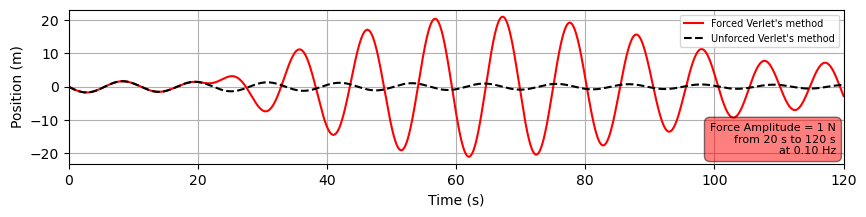

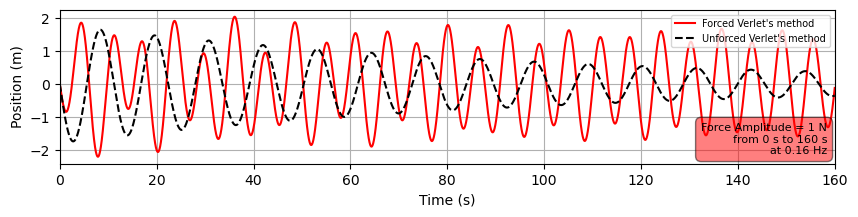

In [24]:
def continuous_force(damping_constant, strength_of_force, start_time, end_time, frequency, hstep):
    """
    Apply a continuous force to a system using the Verlet integration method.

    Parameters:
    - damping_constant (float): Damping coefficient.
    - strength_of_force (float): Amplitude of the force.
    - start_time (float): Start time of the force application.
    - end_time (float): End time of the force application.
    - frequency (float): Frequency of the force.
    - hstep (float): Time step. 0.01 for part 4, 0.1 for part 5 to reduce computational power

    Returns:
    - numpy.ndarray: Array of positions of the system after applying the force.

    """
    # Initial parameters
    nsteps = int(TIME/hstep)
    force = np.zeros(nsteps)

    # Force = None
    x_unforced = verlet_force(nsteps, damping_constant, hstep, force)

    # Force != None
    start_index = int(start_time/hstep)
    end_index = int(end_time/hstep)

    force[start_index:end_index] = strength_of_force * np.sin(2 * np.pi * frequency * np.arange(
        0, TIME, hstep))[start_index:end_index]

    x_forced = verlet_force(nsteps, damping_constant, hstep, force)

    return x_forced


def plot_continuous_force(x_forced, damping_constant, strength_of_force, start_time, end_time, frequency, hstep):
    """
    Plots the forced and unforced Verlet's method for a continuous force.

    Parameters:
    - x_forced (array-like): Array of positions obtained using the forced Verlet's method.
    - damping_constant (float): Damping coefficient.
    - strength_of_force (float): Amplitude of the force.
    - start_time (float): Start time of the force application.
    - end_time (float): End time of the force application.
    - frequency (float): Frequency of the force in Hz
    - hstep (float): Time step. 0.01 for part 4, 0.1 for part 5 to increase computational speed

    Returns:
    None
    """
    hstep = 0.01
    nsteps = int(TIME/hstep)
    x_unforced = verlet_force(nsteps, damping_constant, hstep, force = np.zeros(nsteps))

    plt.figure(figsize=(10, 2))
    plt.plot(np.arange(0, TIME, hstep), x_forced, 'r', label="Forced Verlet's method")
    plt.plot(np.arange(0, TIME, hstep), x_unforced, 'k--', label="Unforced Verlet's method")
    plt.text(0.99, 0.05, 
             f'Force Amplitude = {strength_of_force} N\nfrom {start_time} s to {end_time} s\nat {frequency:.2f} Hz'
             , verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, 
             bbox=dict(facecolor="red", alpha = 0.5, edgecolor="black", 
                       boxstyle = "round, pad = 0.5"), fontsize = 8)
    plt.legend(loc="upper right", fontsize=7)
    format_force_plot()
    

# We use the same values of a damping constant (0.08). Instead of specifying the duration of the force, it is more 
# convenient to specify a start time and end time instead. The start time is 0s for the first plot, and 30s for
# the second plot. The end time is 140s (TIME) for the first plot, and 40s for the second plot. For both, the
# strength of the force is equal at 5N which corresponds to the amplitude of the sin funciton. The freqency is 
# in Hz and 1/(2pi) for the first, and 0.1 for the second. 
TIME = 120 #s
hstep = 0.01

# If you want to change these values, the function takes (damping constant, strength of force, start time, end time
# frequency)
# Function takes scalars only
x_forced = continuous_force(damping_constant, 1, 20, TIME, 0.1, hstep)
plot_continuous_force(x_forced, damping_constant, 1, 20, TIME, 0.1, hstep)

TIME = 160 #s to show steady state
x_forced = continuous_force(damping_constant, 1, 0, TIME, 1/(2*np.pi), hstep)
plot_continuous_force(x_forced, damping_constant, 1, 0, TIME, 1/(2*np.pi), hstep)


When a sinusoidal external force with a frequency different from the undamped natural frequency is applied to the system, resonance effects may occur.

If the frequency of the external force is close to the natural frequency of the system, resonance amplification may occur, leading to significantly increased oscillation amplitudes, such as in the first figure. 
After a transient period, during which the system adjusts to the new frequency of the external force, the oscillations stabilize, reaching a steady state.

The second graph with forced oscillations with a different frequency may show a transient period. In steady state, the oscillations will follow the frequency of the external force, with an amplitude determined by the balance between the driving force and damping.

# Part 5: Finding the resonance plot

To generate the resonance plot, we can reuse the existing function for the sinusoidal force with consistent parameters such as amplitude, start time, and end time. However, we'll vary the frequencies to explore resonance behavior. Extracting the steady-state amplitude from displacement data poses a challenge since the maximum amplitude may not necessarily reflect the system's equilibrium state after the transition period. Instead, we aim to determine the amplitude as time $t \rightarrow \infty$

To ensure each system reaches steady state, the simulation's runtime has been extended to 350 seconds. Peak values are then identified, with emphasis on the last peak as it's most likely to represent the steady state. To speed up the process, the step size has been increased to 0.1. As demonstrated in part 2, this adjustment has minimal impact on the Verlet method's accuracy while significantly enhancing computational speeds.

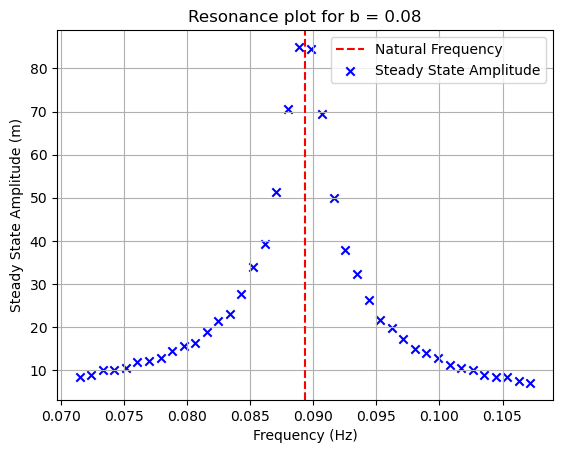

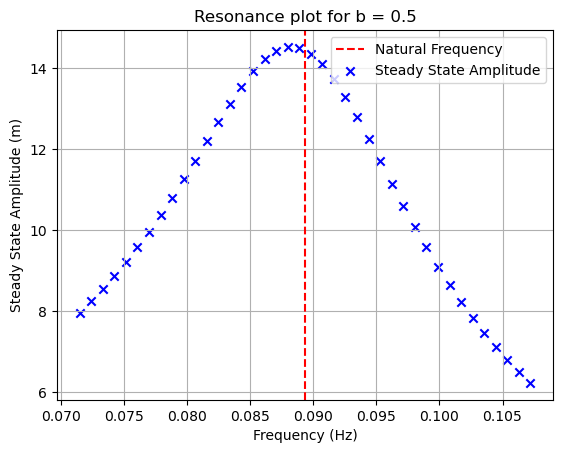

In [25]:
TIME = 350
def resonance_plot(damping_constant):
    """
    Plots the resonance curve for a given damping coefficient and x_limit.

    Parameters:
    - damping_constant (float): The damping coefficient.
    - x_limit (bool): Determines whether to limit the x-axis range.

    Returns:
    None
    """
    natural_frequency = np.sqrt(SPRING_CONSTANT/MASS) / (2 * np.pi)

    frequencies = np.linspace(0.8 * natural_frequency, 1.2 * natural_frequency, 40)

    x_forced = []
    amplitude = []

    # We assume a force with amplitude of 1N, starting at t = 0s and ending at t=TIME (the end of the 
    # simulation period)
    hstep = 0.1 # Increase hstep to increase computational speed
    for frequency in frequencies:
        # Use the same function as above
        x_forced = continuous_force(damping_constant, 1, 0, TIME, frequency, hstep)
        max_amplitudes = x_forced[argrelmax(x_forced)]
        amplitude.append(max_amplitudes[-1])

        
    # Plot the graph
    plt.scatter(frequencies, amplitude, color='b', marker = 'x', label="Steady State Amplitude")

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Steady State Amplitude (m)")
    plt.title(f"Resonance plot for b = {damping_constant}")
    plt.axvline(natural_frequency, color='r', label="Natural Frequency", linestyle="--")
    plt.legend(loc = "upper right")
    plt.grid(True)
    plt.show() 


resonance_plot(0.08)
resonance_plot(0.5)


We can observe some characteristics common to resonance graphs. 

Below the natural frequency: At frequencies below the natural frequency, the system's response lags behind the driving force. The amplitude of oscillation is relatively low as the system tends to resist motion at these frequencies.


At the natural frequency: When the driving frequency matches the natural frequency, resonance occurs. This is where the system's response is maximized, with the displacement amplitude peaking. Energy transfer from the driving force to the system is most efficient at this point.


Above the natural frequency: Beyond the natural frequency, the system's response starts to lead the driving force. The amplitude of oscillation decreases as the frequency increases. The system starts to behave more like a mass moving against a spring, resisting the motion imposed by the external force.

Increasing damping from b = 0.08 to b = 0.5 in a forced mass-spring system suppresses resonance and reduces the amplitude of oscillation across all frequencies.

There are some limitations to calculating the resonance plot using a numerical method. Particularly the first resonance graph is not entirely smooth, but some noise is apparent and does not follow the expected trend. This is because at 350s, not every system will have reached steady state yet, so it's amplitude will be different. To increase the accuracy of the model, the simulation can be run for longer, for example for 400-450s, however, this will increase the time required to produce the graph. 